In [1]:
import operator

import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
meta = {'transformer': {'path': 'gcs://frsght/model_predictions/chad_preds.csv',
                        'fips': 'Code', 'y_pred': 'class_preds',
                        'y_pred_proba': 'preds', 'y_true': 'Spike'},
        'xgboost': {'path': 'gcs://frsght/model_predictions/diana_preds.csv',
                    'fips': 'fips', 'y_pred': 'prediction',
                    'y_pred_proba': 'probabilities', 'y_true': 'lagged_spike'},
        'ffnn': {'path': 'gcs://frsght/model_predictions/evan_preds.csv',
                 'fips': 'fips', 'y_pred': 'preds',
                 'y_pred_proba': 'preds_proba', 'y_true': 'Spike_3'},
        'ensemble': {'fips': 'fips', 'y_pred': 'y_pred',
                     'y_pred_proba': 'y_pred_proba', 'y_true': 'y_true'}}

In [3]:
dft = pd.read_csv("gcs://frsght/model_predictions/chad_preds.csv")
dft['model'] = 'transformer'
dfx = pd.read_csv("gcs://frsght/model_predictions/diana_preds.csv")
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfx['model'] = 'xgboost'
dfn = pd.read_csv("gcs://frsght/model_predictions/evan_preds.csv")
dfn['model'] = 'ffnn'

In [4]:
# create alternate df versions with same columns
_dft = dft.rename(columns={'Code': 'fips', 'class_preds': 'y_pred',
                           'preds': 'y_pred_proba', 'Spike': 'y_true'})
_dft = _dft[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']].set_index(['yearmonth', 'fips'])
_dfx = dfx.rename(columns={'prediction': 'y_pred',
                           'probabilities': 'y_pred_proba', 'lagged_spike': 'y_true'})
_dfx = _dfx[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']].set_index(['yearmonth', 'fips'])

_dfn = dfn.rename(columns={'preds': 'y_pred',
                           'preds_proba': 'y_pred_proba', 'Spike_3': 'y_true'})
_dfn = _dfn[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']].set_index(['yearmonth', 'fips'])

In [5]:
# create 'ensemble' df with mean prediction probabilities from all models
_dfe = _dft.merge(_dfn, left_index=True, right_index=True, suffixes=('_t', '_x'))
_dfe = _dfe.merge(_dfn, left_index=True, right_index=True, suffixes=('_a', '_n'))

dfe = pd.DataFrame({'y_pred_proba': _dfe[['y_pred_proba_t','y_pred_proba_x', 'y_pred_proba']].mean(axis=1),
                    'y_true': _dfe['y_true_t']})
dfe['y_pred'] = dfe['y_pred_proba'].round().astype(bool)
dfe

y_pred_proba  y_true  y_pred
yearmonth fips                              
202211    AF        0.472255   False   False
          AF        0.472255   False   False
          AG        0.508491   False    True
          AG        0.508491   False    True
          AJ        0.517190   False    True
...                      ...     ...     ...
202301    YM        0.488955   False   False
          ZA        0.536747    True    True
          ZA        0.536747    True    True
          ZI        0.571429    True    True
          ZI        0.571429    True    True

[582 rows x 3 columns]

In [6]:
dfs = {'transformer': dft, 'xgboost': dfx, 'ffnn': dfn}#, 'ensemble': dfe}

In [7]:
for m, df in dfs.items():
    bools = ['y_pred', 'y_true']
    for b in bools:
        df[meta[m][b]] = df[meta[m][b]].astype(bool)
    print('>>> ', m, df.shape)
    print(metrics.confusion_matrix(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n')
    print(metrics.classification_report(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n\n')

>>>  transformer (1484, 13)
[[990 318]
 [ 96  80]] 

              precision    recall  f1-score   support

       False       0.91      0.76      0.83      1308
        True       0.20      0.45      0.28       176

    accuracy                           0.72      1484
   macro avg       0.56      0.61      0.55      1484
weighted avg       0.83      0.72      0.76      1484
 


>>>  xgboost (478, 9)
[[238 185]
 [ 17  38]] 

              precision    recall  f1-score   support

       False       0.93      0.56      0.70       423
        True       0.17      0.69      0.27        55

    accuracy                           0.58       478
   macro avg       0.55      0.63      0.49       478
weighted avg       0.85      0.58      0.65       478
 


>>>  ffnn (390, 7)
[[168  80]
 [ 93  49]] 

              precision    recall  f1-score   support

       False       0.64      0.68      0.66       248
        True       0.38      0.35      0.36       142

    accuracy                    

In [8]:
# list of sklearn.metrics functions that expect args `y_true` and `y_pred`
# nice explanations here: https://neptune.ai/blog/evaluation-metrics-binary-classification
# cohen kappa: how much better is your model over the random classifier that predicts based on class frequencies
# matthews: a correlation between predicted classes and ground truth
bin_metrics = ['f1_score', 'accuracy_score', 'precision_score', 'recall_score',
               'cohen_kappa_score', 'matthews_corrcoef']

out = list()

for m, df in dfs.items():
    for metric in bin_metrics:
        fun = operator.methodcaller(metric, df[meta[m]['y_true']],
                                    df[meta[m]['y_pred']])
        out.append((m, metric, fun(metrics), 'max'))
    out.append((m, 'roc_auc_score', metrics.roc_auc_score(df[meta[m]['y_true']],
                                                          df[meta[m]['y_pred_proba']]), 'max'))
    
    tn, fp, fn, tp = metrics.confusion_matrix(df[meta[m]['y_true']],
                                              df[meta[m]['y_pred']]).ravel()
    
    # how many predictions out of all positive predictions were incorrect
    false_discovery_rate = fp/ (tp + fp)
    out.append((m, 'false_discovery_rate', false_discovery_rate, 'min'))
    
    # how many observations predicted as positive are in fact positive
    positive_predictive_value = tp/ (tp + fp)
    out.append((m, 'positive_predictive_value', positive_predictive_value, 'max'))
    
    # how many predictions out of all negative predictions were correct
    negative_predictive_value = tn/ (tn + fn)
    out.append((m, 'negative_predictive_value', negative_predictive_value, 'max'))
       
    false_positive_rate = fp / (fp + tn)
    out.append((m, 'false_positive_rate', false_positive_rate, 'min'))
    
    false_negative_rate = fn / (tp + fn)
    out.append((m, 'false_negative_rate', false_negative_rate, 'min'))
    
    true_positive_rate = tp / (tp + fn)
    out.append((m, 'true_positive_rate', true_positive_rate, 'max'))
    
    true_negative_rate = tn / (tn + fp)
    out.append((m, 'true_negative_rate', true_negative_rate, 'max'))

In [9]:
max_best = ['true_negative_rate', 'negative_predictive_value', 'true_positive_rate',
            'positive_predictive_value', 'f1_score', 'accuracy_score', 'precision_score',
            'recall_score', 'cohen_kappa_score', 'matthews_corrcoef' 'roc_auc_score',]
min_best = ['false_negative_rate', 'false_discovery_rate', 'false_positive_rate',]

In [10]:
model_metrics = pd.DataFrame(out, columns=('model', 'metric', 'value', 'best'))

In [11]:
# max value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='max']
                   .groupby(["metric"])["value"]
                   .idxmax()][['metric', 'model', 'value']])

,metric,model,value
1,accuracy_score,transformer,0.721024
4,cohen_kappa_score,transformer,0.136773
28,f1_score,ffnn,0.361624
19,matthews_corrcoef,xgboost,0.162183
23,negative_predictive_value,xgboost,0.933333
36,positive_predictive_value,ffnn,0.379845
30,precision_score,ffnn,0.379845
17,recall_score,xgboost,0.690909
20,roc_auc_score,xgboost,0.721212
13,true_negative_rate,transformer,0.756881


In [12]:
# min value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='min']
                   .groupby(["metric"])["value"]
                   .idxmin()][['metric', 'model', 'value']])

,metric,model,value
35,false_discovery_rate,ffnn,0.620155
25,false_negative_rate,xgboost,0.309091
10,false_positive_rate,transformer,0.243119


In [13]:
#| label: tbl-min-best-broken
#| fig-cap: "Table that breaks article column layout in quarto"
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("red", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
(model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
     .sort_values('metric')
     .style
        .background_gradient(cmap=cm)
        .format(precision=3)
        .hide(axis="index"))

metric,model,value
false_discovery_rate,transformer,0.799
false_discovery_rate,xgboost,0.830
false_discovery_rate,ffnn,0.620
false_negative_rate,transformer,0.545
false_negative_rate,xgboost,0.309
false_negative_rate,ffnn,0.655
false_positive_rate,transformer,0.243
false_positive_rate,xgboost,0.437
false_positive_rate,ffnn,0.323


In [14]:
#| label: tbl-max-best-broken
#| fig-cap: "Table that breaks article column layout in quarto"
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("green", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
(model_metrics[model_metrics.best=='max'][['metric', 'model', 'value']]
     .sort_values('metric')
     .style
        .background_gradient(cmap=cm)
        .format(precision=3)
        .hide(axis="index"))

metric,model,value
accuracy_score,transformer,0.721
accuracy_score,ffnn,0.556
accuracy_score,xgboost,0.577
cohen_kappa_score,ffnn,0.023
cohen_kappa_score,transformer,0.137
cohen_kappa_score,xgboost,0.109
f1_score,transformer,0.279
f1_score,ffnn,0.362
f1_score,xgboost,0.273
matthews_corrcoef,ffnn,0.023


In [15]:
#| label: tbl-best-max-metrics
#| fig-cap: "Binary classification model metrics (max value is best)"
#| layout-ncol: 1

# TODO use of styler (above) messes up column widths,
# so just plain print for now
print(model_metrics[model_metrics.best=='max'][['metric', 'model', 'value']]
          .sort_values('metric')
          .to_string(index=False))

                   metric       model    value
           accuracy_score transformer 0.721024
           accuracy_score        ffnn 0.556410
           accuracy_score     xgboost 0.577406
        cohen_kappa_score        ffnn 0.022939
        cohen_kappa_score transformer 0.136773
        cohen_kappa_score     xgboost 0.108884
                 f1_score transformer 0.278746
                 f1_score        ffnn 0.361624
                 f1_score     xgboost 0.273381
        matthews_corrcoef        ffnn 0.023001
        matthews_corrcoef     xgboost 0.162183
        matthews_corrcoef transformer 0.154299
negative_predictive_value     xgboost 0.933333
negative_predictive_value transformer 0.911602
negative_predictive_value        ffnn 0.643678
positive_predictive_value transformer 0.201005
positive_predictive_value        ffnn 0.379845
positive_predictive_value     xgboost 0.170404
          precision_score        ffnn 0.379845
          precision_score transformer 0.201005
          pre

In [16]:
#| label: tbl-best-min-metrics
#| fig-cap: "Binary classification model metrics (min value is best)"
#| layout-ncol: 1

# TODO use of styler (above) messes up column widths,
# so just plain print for now
print(model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
          .sort_values('metric')
          .to_string(index=False))

              metric       model    value
false_discovery_rate transformer 0.798995
false_discovery_rate     xgboost 0.829596
false_discovery_rate        ffnn 0.620155
 false_negative_rate transformer 0.545455
 false_negative_rate     xgboost 0.309091
 false_negative_rate        ffnn 0.654930
 false_positive_rate transformer 0.243119
 false_positive_rate     xgboost 0.437352
 false_positive_rate        ffnn 0.322581


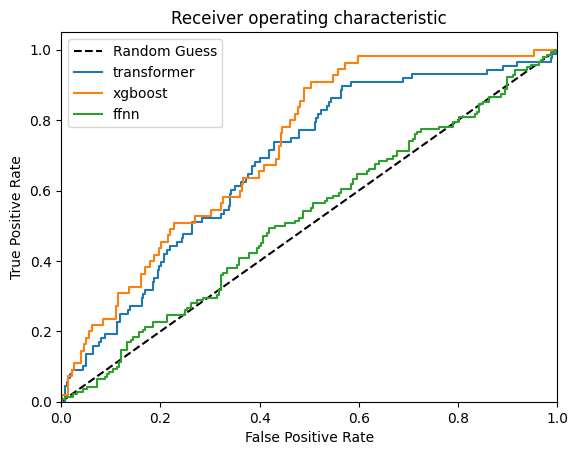

In [17]:
#| label: fig-roc
#| fig-cap: "Receiver operating characteristic"
#| fig-subcap: 
#|   - "Comparison of model ROC"
#| fig-alt:
#|   - "ROC plot of models"
#| layout-ncol: 1

plt.figure()
plt.plot([0,1],[0,1], "k--", label='Random Guess')

for m, df in dfs.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = metrics.roc_curve(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.plot(fpr[1], tpr[1], label=m)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.show()

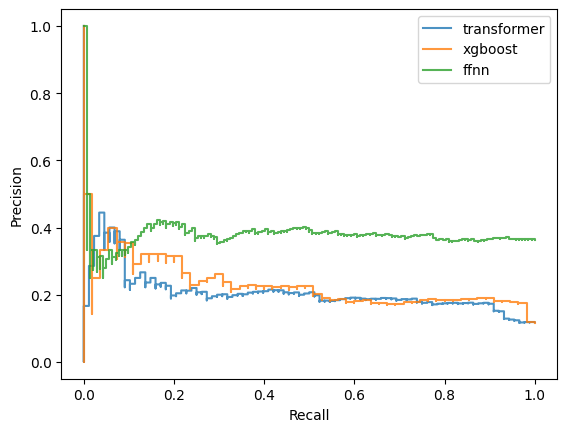

In [18]:
#| label: fig-prc
#| fig-cap: "Precision recall curve"
#| fig-subcap: 
#|   - "Comparison of model precision recall curves"
#| fig-alt:
#|   - "PRC plot of models"
#| layout-ncol: 1

ax = plt.gca()
for m, df in dfs.items():
    precision, recall, threshold = metrics.precision_recall_curve(df[meta[m]['y_true']], 
                                                                  df[meta[m]['y_pred_proba']])
    prd = metrics.PrecisionRecallDisplay(precision, recall)
    prd.plot(ax=ax, alpha=0.8, label=m)
plt.legend(loc="best")
plt.show()